In [1]:
!pip install pandas
!pip install accelerate
!pip install transformers
import accelerate
import torch
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset
import numpy as np
from torch.utils.data import TensorDataset
from transformers import TrainingArguments, Trainer
import matplotlib.pyplot as plt

In [2]:
from google.colab import files
import pandas as pd

uploaded = files.upload()

Saving PromiseEval_Sample_Trainset_English.json to PromiseEval_Sample_Trainset_English.json
Saving PromiseEval_Trainset_English.json to PromiseEval_Trainset_English.json


In [3]:
import pandas as pd

json_file1 = '/content/PromiseEval_Sample_Trainset_English.json'
json_file2=  '/content/PromiseEval_Trainset_English.json'
csv_file = '/content/data.csv'  # Replace with your desired CSV file name

# Read the JSON file
df1 = pd.read_json(json_file1)
df2 = pd.read_json(json_file2)

# Concatenate the DataFrames
df = pd.concat([df1, df2], ignore_index=True)

# Convert to CSV
df.to_csv(csv_file, index=False)
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df['promise_status'] = df['promise_status'].replace({'Yes': 1, 'No': 0})
df['evidence_status'] = df['evidence_status'].replace({'Yes': 1, 'No': 0})
print(f'JSON has been successfully converted to CSV: {csv_file}')


JSON has been successfully converted to CSV: /content/data.csv


<ipython-input-3-09dbd61cf581>:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
<ipython-input-3-09dbd61cf581>:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['promise_status'] = df['promise_status'].replace({'Yes': 1, 'No': 0})
<ipython-input-3-09dbd61cf581>:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['evidence_status'] = df['evidence_status'].replace({'Yes': 1, 'No': 0})


In [4]:
ver_df = df.copy()
qua_df = df.copy()
df

,URL,page_number,data,promise_status,verification_timeline,evidence_status,evidence_quality
0,https://r.lvmh-static.com/uploads/2023/06/06-2...,10,“LVMH is transforming the luxury industry.”PRO...,0,N/A,0,N/A
1,https://r.lvmh-static.com/uploads/2023/06/06-2...,13,“Each of us has the teams required to achieve ...,0,N/A,0,N/A
2,https://r.lvmh-static.com/uploads/2023/06/06-2...,14,“The LVMH Prize has allowed me to help change ...,0,N/A,0,N/A
3,https://r.lvmh-static.com/uploads/2023/06/06-2...,15,“LVMH shows an extraordinary level of commitme...,0,N/A,0,N/A
4,https://r.lvmh-static.com/uploads/2023/06/06-2...,16,GROUP-WIDE OVERSIGHT BODIES The Board-level Et...,0,N/A,0,N/A
...,...,...,...,...,...,...,...
595,https://www.baytexenergy.com/content/uploads/2...,29,Continual improvement We follow up on high-pot...,1,Already,1,Not Clear
596,https://www.baytexenergy.com/content/uploads/2...,29,Emergency preparedness We maintain and rehears...,1,Already,1,Clear
597,https://www.baytexenergy.com/content/uploads/2...,80,The climate policies and regulations most rele...,0,N/A,0,N/A
598,https://www.baytexenergy.com/content/uploads/2...,80,SENSITIVITY ANALYSIS As part of the scenario a...,1,More than 5 years,1,Clear


In [5]:
ver_df = ver_df.drop('page_number', axis=1)
ver_df = ver_df.drop('URL', axis=1)
ver_df = ver_df.drop('evidence_status', axis=1)
ver_df = ver_df.drop('evidence_quality', axis=1)

ver_df['verification_timeline'] = ver_df['verification_timeline'].str.strip()
df_bin = pd.get_dummies(ver_df['verification_timeline'])
vdf_final = pd.concat([ver_df, df_bin], axis=1)
vdf_final = vdf_final.drop('verification_timeline', axis=1)
bool_cols = vdf_final.select_dtypes(include='bool').columns
vdf_final[bool_cols] = vdf_final[bool_cols].astype(int)
vdf_final

,data,promise_status,2 to 5 years,Already,Less than 2 years,More than 5 years,N/A
0,“LVMH is transforming the luxury industry.”PRO...,0,0,0,0,0,1
1,“Each of us has the teams required to achieve ...,0,0,0,0,0,1
2,“The LVMH Prize has allowed me to help change ...,0,0,0,0,0,1
3,“LVMH shows an extraordinary level of commitme...,0,0,0,0,0,1
4,GROUP-WIDE OVERSIGHT BODIES The Board-level Et...,0,0,0,0,0,1
...,...,...,...,...,...,...,...
595,Continual improvement We follow up on high-pot...,1,0,1,0,0,0
596,Emergency preparedness We maintain and rehears...,1,0,1,0,0,0
597,The climate policies and regulations most rele...,0,0,0,0,0,1
598,SENSITIVITY ANALYSIS As part of the scenario a...,1,0,0,0,1,0


In [6]:
# unique_counts = qua_df['evidence_status'].value_counts()
# unique_counts

In [7]:
qua_df = qua_df.drop('page_number', axis=1)
qua_df = qua_df.drop('URL', axis=1)
qua_df = qua_df.drop('verification_timeline', axis=1)

qua_df['evidence_quality'] = qua_df['evidence_quality'].str.strip()
df_bin = pd.get_dummies(qua_df['evidence_quality'])
qdf_final = pd.concat([qua_df, df_bin], axis=1)
qdf_final = qdf_final.drop('evidence_quality', axis=1)
bool_cols = qdf_final.select_dtypes(include='bool').columns
qdf_final[bool_cols] = qdf_final[bool_cols].astype(int)
qdf_final

,data,promise_status,evidence_status,Clear,Misleading,N/A,Not Clear
0,“LVMH is transforming the luxury industry.”PRO...,0,0,0,0,1,0
1,“Each of us has the teams required to achieve ...,0,0,0,0,1,0
2,“The LVMH Prize has allowed me to help change ...,0,0,0,0,1,0
3,“LVMH shows an extraordinary level of commitme...,0,0,0,0,1,0
4,GROUP-WIDE OVERSIGHT BODIES The Board-level Et...,0,0,0,0,1,0
...,...,...,...,...,...,...,...
595,Continual improvement We follow up on high-pot...,1,1,0,0,0,1
596,Emergency preparedness We maintain and rehears...,1,1,1,0,0,0
597,The climate policies and regulations most rele...,0,0,0,0,1,0
598,SENSITIVITY ANALYSIS As part of the scenario a...,1,1,1,0,0,0


In [8]:
qdf_final.to_csv('/content/qdata.csv' , index=False)
vdf_final.to_csv('/content/vdata.csv' , index=False)

In [12]:
label_df = vdf_final[['data',	'promise_status',	'2 to 5 years',	'Already',	'Less than 2 years',	'More than 5 years',	'N/A']]
label_df

,data,promise_status,2 to 5 years,Already,Less than 2 years,More than 5 years,N/A
0,“LVMH is transforming the luxury industry.”PRO...,0,0,0,0,0,1
1,“Each of us has the teams required to achieve ...,0,0,0,0,0,1
2,“The LVMH Prize has allowed me to help change ...,0,0,0,0,0,1
3,“LVMH shows an extraordinary level of commitme...,0,0,0,0,0,1
4,GROUP-WIDE OVERSIGHT BODIES The Board-level Et...,0,0,0,0,0,1
...,...,...,...,...,...,...,...
595,Continual improvement We follow up on high-pot...,1,0,1,0,0,0
596,Emergency preparedness We maintain and rehears...,1,0,1,0,0,0
597,The climate policies and regulations most rele...,0,0,0,0,0,1
598,SENSITIVITY ANALYSIS As part of the scenario a...,1,0,0,0,1,0


In [13]:
train_df = label_df[:500]
validation_df = label_df[500:570]
test_df = label_df[570:]
train_labels_df = label_df[:500]
validation_labels_df = label_df[500:570]
test_labels_df = label_df[570:]

In [14]:
train_sentences = train_df['data'].values.tolist()
train_labels = train_labels_df.iloc[:, 1:].values
train_labels = train_labels.astype(np.float32)

validation_sentences = validation_df['data'].values.tolist()
validation_labels = validation_labels_df.iloc[:, 1:].values
validation_labels = validation_labels.astype(np.float32)

In [15]:
from transformers import AutoTokenizer

checkpoint = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

model = BertForSequenceClassification.from_pretrained(checkpoint, num_labels=6, problem_type="multi_label_classification")
model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
You are using a model of type xlm-roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.wei

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [16]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir=".",
    evaluation_strategy="epoch",
    logging_dir="./logs",
    save_strategy="epoch",
    num_train_epochs = 8,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    load_best_model_at_end=True,
    weight_decay=0.01,
    learning_rate = 8e-6,
    warmup_steps = 30,
    logging_steps= 100,
    metric_for_best_model="f1"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [17]:
class ArgDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [18]:
train_encodings = tokenizer(train_sentences, padding = True, truncation = True, max_length = 512)
train_dataset = ArgDataset(train_encodings, train_labels)

validation_encodings = tokenizer(validation_sentences, padding = True, truncation = True, max_length = 512)
validation_dataset = ArgDataset(validation_encodings, validation_labels)

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

label_names = train_labels_df.columns[1:].tolist()

def compute_metrics(pred):
    labels = pred.label_ids
    preds = (pred.predictions > 0.5).astype(int)  # Convert probabilities to binary predictions

    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted', zero_division=0)
    recall = recall_score(labels, preds, average='weighted', zero_division=0)
    f1 = f1_score(labels, preds, average='weighted', zero_division=0)

    # Generate classification report
    # report = classification_report(labels, preds, target_names=label_names, zero_division=0)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        # 'classification_report': report
    }

import wandb
wandb.init(mode="disabled")

In [20]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.505030,0.000000,0.326249,0.430894,0.371340
2,No log,0.486300,0.000000,0.326249,0.430894,0.371340
3,No log,0.497940,0.000000,0.326249,0.430894,0.371340
4,0.472500,0.492697,0.000000,0.326249,0.430894,0.371340
5,0.472500,0.475301,0.000000,0.326249,0.430894,0.371340
6,0.472500,0.469070,0.000000,0.327994,0.414634,0.366260
7,0.421000,0.460954,0.000000,0.336636,0.406504,0.368286
8,0.421000,0.479153,0.000000,0.326435,0.406504,0.362096


TrainOutput(global_step=256, training_loss=0.43623044341802597, metrics={'train_runtime': 653.6002, 'train_samples_per_second': 6.12, 'train_steps_per_second': 0.392, 'total_flos': 1052482019328000.0, 'train_loss': 0.43623044341802597, 'epoch': 8.0})

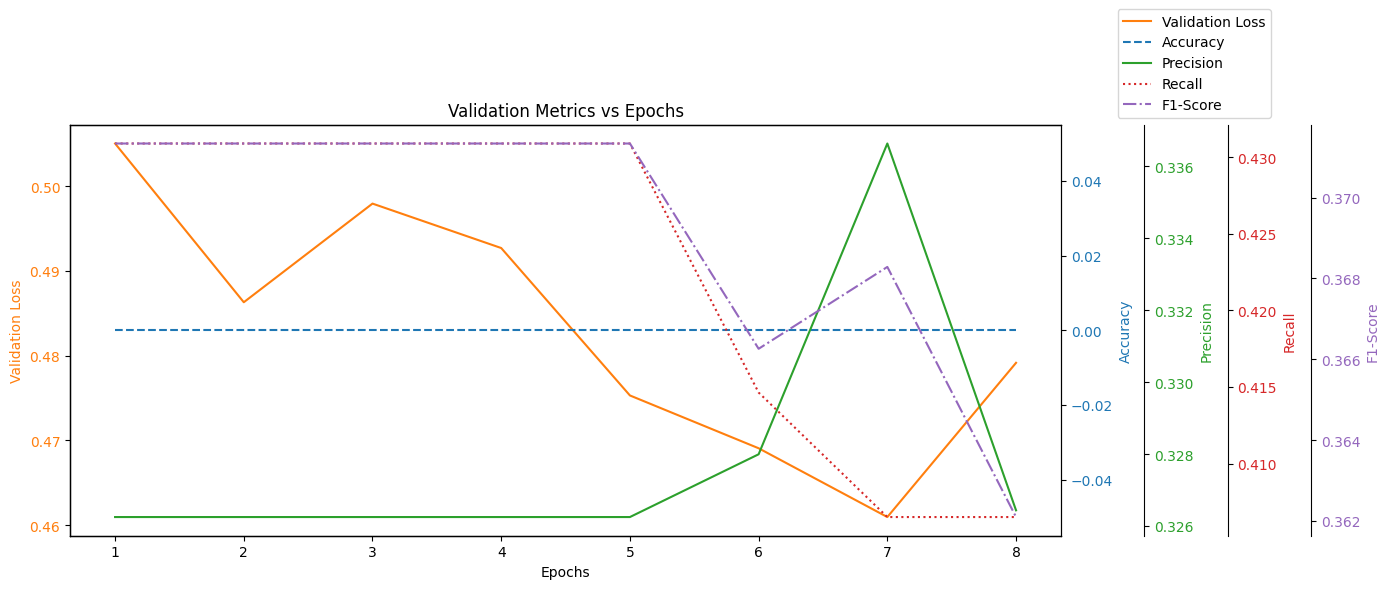

In [21]:
import matplotlib.pyplot as plt

# Extract the log history from the trainer
log_history = trainer.state.log_history

# Initialize lists for storing values
losses = []
accuracies = []
precisions = []
f1_scores = []
recalls = []

# Parse through the log history and extract values
for entry in log_history:
    if 'eval_loss' in entry and 'eval_accuracy' in entry and 'eval_precision' in entry and 'eval_recall' in entry and 'eval_f1' in entry:
        losses.append(entry['eval_loss'])
        accuracies.append(entry['eval_accuracy'])
        precisions.append(entry['eval_precision'])
        f1_scores.append(entry['eval_f1'])
        recalls.append(entry['eval_recall'])

# Define epochs (adjust based on your actual epoch range)
epochs = list(range(1, len(losses) + 1))

# Create a figure and axis for plotting
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot the first metric (loss) on the primary y-axis
ax1.plot(epochs, losses, color='tab:orange', label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Validation Loss', color='tab:orange')
ax1.tick_params(axis='y', labelcolor='tab:orange')

# Create a secondary y-axis for Accuracy
ax2 = ax1.twinx()
ax2.plot(epochs, accuracies, color='tab:blue', linestyle='--', label='Accuracy')
ax2.set_ylabel('Accuracy', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Create a tertiary y-axis for Precision
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third y-axis
ax3.plot(epochs, precisions, color='tab:green', linestyle='-', label='Precision')
ax3.set_ylabel('Precision', color='tab:green')
ax3.tick_params(axis='y', labelcolor='tab:green')

# Create a fourth y-axis for Recall
ax4 = ax1.twinx()
ax4.spines['right'].set_position(('outward', 120))  # Offset the fourth y-axis
ax4.plot(epochs, recalls, color='tab:red', linestyle=':', label='Recall')
ax4.set_ylabel('Recall', color='tab:red')
ax4.tick_params(axis='y', labelcolor='tab:red')

# Create a fifth y-axis for F1-score
ax5 = ax1.twinx()
ax5.spines['right'].set_position(('outward', 180))  # Offset the fifth y-axis
ax5.plot(epochs, f1_scores, color='tab:purple', linestyle='-.', label='F1-Score')
ax5.set_ylabel('F1-Score', color='tab:purple')
ax5.tick_params(axis='y', labelcolor='tab:purple')

# Add legends for each line
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
lines4, labels4 = ax4.get_legend_handles_labels()
lines5, labels5 = ax5.get_legend_handles_labels()

ax2.legend(lines1 + lines2 + lines3 + lines4 + lines5,
           labels1 + labels2 + labels3 + labels4 + labels5,
           loc='lower left', bbox_to_anchor=(1.05, 1))

# Title and grid
plt.title('Validation Metrics vs Epochs')
plt.grid(False)

# Show the plot
plt.tight_layout()
plt.show()


In [22]:
model.save_pretrained("/content/")
model = BertForSequenceClassification.from_pretrained("/content/")

In [23]:
test_df.insert(0, 'Index', range(1, len(test_labels_df) + 1))
test_labels_df.insert(0, 'Index', range(1, len(test_labels_df) + 1))
test_labels_df

,Index,data,promise_status,2 to 5 years,Already,Less than 2 years,More than 5 years,N/A
570,1,Workforce diversity 2022 highlights Nonkululek...,0,0,0,0,0,1
571,2,Four of the board’s subcommittees are chaired ...,0,0,0,0,0,1
572,3,Margaret Nienaber was promoted to take on the ...,0,0,0,0,0,1
573,4,"34.8% of our executives are women, against our...",1,0,0,1,0,0
574,5,"In South Africa, representation of African men...",1,0,0,1,0,0
575,6,"Business responsibilities Relevant executives,...",0,0,0,0,0,1
576,7,Group corporate citizenship Reports to CRO De...,0,0,0,0,0,1
577,8,"Heads of legal entities, client segments and s...",0,0,0,0,0,1
578,9,Client risk committees Assess issues related ...,0,0,0,0,0,1
579,10,Supplier risk committees Review issues relate...,0,0,0,0,0,1


In [26]:
predictions = []
threshold = 0.4

for idx, row in test_df.iterrows():
    arg_id = row['Index']
    text = row['data']
    encoding = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**encoding)

    sigmoid = torch.nn.Sigmoid()
    predictions_tensor = sigmoid(outputs.logits)

    predicted_labels = []
    for prob in predictions_tensor.flatten():
        if prob >= threshold:
          label = 1
        else:
          label =  0
        predicted_labels.append(label)

    predictions.append([arg_id] + predicted_labels)

data = {'Index': [entry[0] for entry in predictions]}

for i, label in enumerate(test_labels_df.columns[2:]):
    data[label] = [entry[i+1] for entry in predictions]
predictions_df = pd.DataFrame(data)


In [27]:
true_pred = test_labels_df[['Index','promise_status',	'2 to 5 years',	'Already',	'Less than 2 years',	'More than 5 years',	'N/A']]

In [30]:
# true_labels = true_pred[['promise_status',	'2 to 5 years',	'Already',	'Less than 2 years',	'More than 5 years',	'N/A']]
# pred_labels = predictions_df[['promise_status',	'2 to 5 years',	'Already',	'Less than 2 years',	'More than 5 years',	'N/A']]
true_labels = true_pred[['promise_status']]
pred_labels = predictions_df[['promise_status']]

f1_average = f1_score(true_labels, pred_labels, average='macro')
print(f"Average F1 Score: {f1_average}")

Average F1 Score: 0.3181818181818182
